### This notebook uses LDA (Latent Dirichlet Allocation) to check possible activity-related response topics

In [1]:
import sys, os
DMOL_DIR = "../"
sys.path.append(os.path.join(DMOL_DIR, "utils"))

from ml_utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# LDA
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
from pprint import pprint


# For viz
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../data/open_ended_responses.csv")
assert(os.path.exists("../slides_dataviz/plots/"))

In [3]:
def prepare_lda(text_list):
    preprocessed_text = [nlp_preprocess(act).split() for act in text_list]
    id2word = gensim.corpora.Dictionary(preprocessed_text)
    # Gensim Count Vector
    bow_corpus = [id2word.doc2bow(act) for act in preprocessed_text]
    # for i,c in enumerate(bow_corpus):
    #     if len(c) >= 5:
    #         print("Original sentence:  {}".format(oact[i]))
    #         for i in c:
    #             print("word {} appeared {} times".format(word_dictionary[i[0]], i[1]))
    #         break

    # Convert Count to td-idf score
    tfidf = models.TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[bow_corpus]
    return preprocessed_text, id2word, corpus_tfidf
    
def find_num_topics(num_topic_min, num_topic_max, text, id2word, corpus, verbose = True, fname = None):
# lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=id2word, passes=2, workers=2)
    coherence_score = []
    for num_topics in range(num_topic_min, num_topic_max + 1):
        lda_model_tfidf = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=id2word, random_state = 100,  
                                                     chunksize=50,passes=50, per_word_topics = True, workers = 5)
        coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=text, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        if verbose:
            print('num_topics = {}   \tCoherence Score:  {}\tPerplexity: {}'.format(num_topics, coherence_lda, lda_model_tfidf.log_perplexity(corpus)))
        coherence_score.append(coherence_lda)
    
    plt.figure(figsize = (13.8, 6))
    sns.set_style('whitegrid')
    plt.plot(list(range(num_topic_min, num_topic_max + 1)), coherence_score, '-ko')
    plt.title("Coherence Score vs Num Topics",fontsize=22)
    plt.xlabel("Num Topics", fontsize=18)
    plt.ylabel("Coherence Score", fontsize=18)
    plt.xticks(list(range(num_topic_min, num_topic_max + 1)))
    plt.tick_params(labelsize=14)
    if fname is not None:
        plt.savefig(fname, format='eps', dpi=1200)
    plt.show()
    return coherence_score

def check_topics(num_topics, texts, id2word, corpus):
    lda_model_tfidf = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=id2word, 
                                                 random_state = 100,  chunksize=50,
                                                 passes=50, per_word_topics = True, workers = 5)
    coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('num_topics = {} \t Coherence Score:  {} \t Perplexity: {}\n'.format(num_topics, coherence_lda, lda_model_tfidf.log_perplexity(corpus)))
    for idx, topic in lda_model_tfidf.print_topics(-1):
        print('Topics: {} \nWords: {}'.format(idx, topic))
    
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus, id2word)
    return vis, lda_model_tfidf

def plot_topics(model, fname = None, nrow = 2, ncol = 2):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

    cloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: '#000000',
                      prefer_horizontal=1.0)

    topics = model.show_topics(formatted=False)

    fig, axes = plt.subplots(nrow, ncol, figsize=(13.8,6), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=22))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    if fname is not None:
        plt.savefig(fname, format='eps', dpi=1200)
    return ax

# Other Activities Analysis

In [4]:
oact_col_names = [c for c in df.columns if "oact" in c and "compx" not in c]
oact = [act for c in oact_col_names for act in df[df[c].notnull()].loc[1:, c]]
preprocessed_oact, id2word_oact, corpus_tfidf_oact = prepare_lda(oact)
print("Num of Documents:  ", len(preprocessed_oact))
print("Num of Uniq Words:  ", len(id2word_oact))

Num of Documents:   2293
Num of Uniq Words:   586


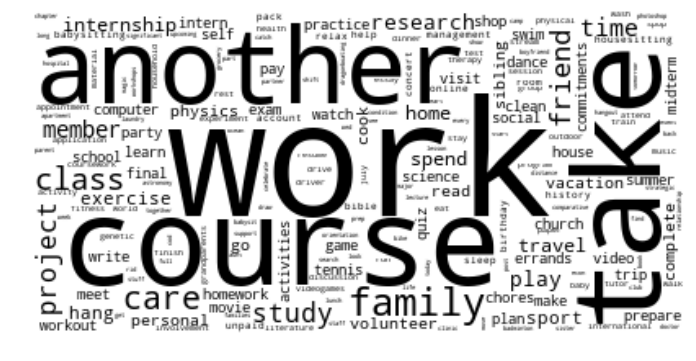

In [5]:
generate_wordcloud(preprocessed_oact)

num_topics = 1   	Coherence Score:  0.7094529995230369	Perplexity: -5.233848863316372
num_topics = 2   	Coherence Score:  0.7061955382965976	Perplexity: -5.367334154327259
num_topics = 3   	Coherence Score:  0.7424611449346891	Perplexity: -5.508141300175065
num_topics = 4   	Coherence Score:  0.7488157220250826	Perplexity: -5.604493403030943
num_topics = 5   	Coherence Score:  0.7400886494039411	Perplexity: -5.643713599203409
num_topics = 6   	Coherence Score:  0.7349101449785641	Perplexity: -5.745192473625291
num_topics = 7   	Coherence Score:  0.7159602346071302	Perplexity: -5.767144546154679
num_topics = 8   	Coherence Score:  0.7166598956076013	Perplexity: -5.816501482951703
num_topics = 9   	Coherence Score:  0.691743156762889	Perplexity: -6.152449501456632
num_topics = 10   	Coherence Score:  0.697800292408461	Perplexity: -6.287797076165361
num_topics = 11   	Coherence Score:  0.7060764831063608	Perplexity: -6.369569191135719


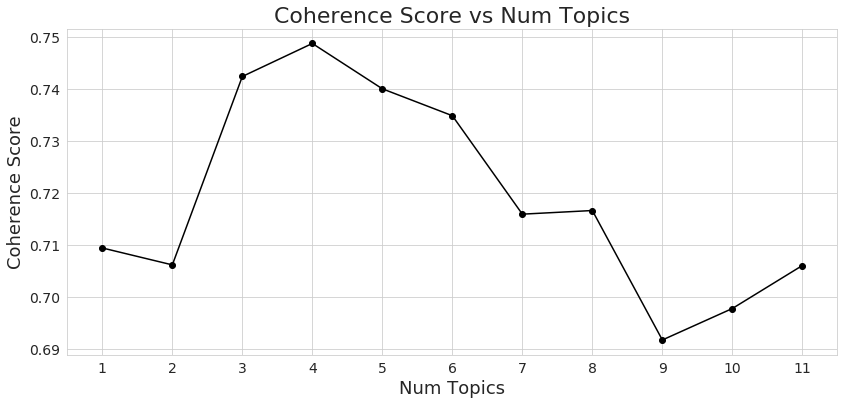

In [6]:
coherence_scores_oact = find_num_topics(1, 11, preprocessed_oact, id2word_oact, corpus_tfidf_oact, 
                                        fname = "../slides_dataviz/plots/lda_oact_coherence.eps")

In [7]:
viz, model_oact_4 = check_topics(4, preprocessed_oact, id2word_oact, corpus_tfidf_oact)

num_topics = 4 	 Coherence Score:  0.7302565718899569 	 Perplexity: -5.5926588061291564

Topics: 0 
Words: 0.132*"family" + 0.079*"care" + 0.053*"research" + 0.047*"members" + 0.025*"clean" + 0.022*"church" + 0.021*"errands" + 0.021*"go" + 0.019*"house" + 0.018*"watch"
Topics: 1 
Words: 0.144*"course" + 0.119*"take" + 0.118*"another" + 0.023*"physics" + 0.020*"read" + 0.016*"vacation" + 0.016*"school" + 0.015*"siblings" + 0.014*"intern" + 0.013*"quiz"
Topics: 2 
Words: 0.080*"class" + 0.050*"time" + 0.049*"friends" + 0.043*"project" + 0.039*"travel" + 0.039*"study" + 0.037*"exercise" + 0.036*"spend" + 0.036*"internship" + 0.032*"hang"
Topics: 3 
Words: 0.348*"work" + 0.056*"cook" + 0.036*"volunteer" + 0.034*"chores" + 0.021*"management" + 0.019*"july" + 0.017*"fitness" + 0.014*"write" + 0.012*"search" + 0.012*"learn"


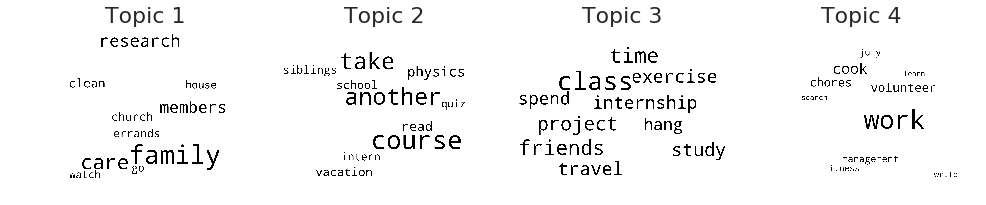

In [8]:
plot_topics(model_oact_4, "../slides_dataviz/plots/lda_oact_model_4_topics.eps", nrow=1, ncol=4)

# Course-related activities Analysis

In [9]:
cact_col_names = ["dcact{}".format(i) for i in range(1, 31)]
cact = [act for c in cact_col_names for act in df[df[c].notnull()].loc[1:, c]]
preprocessed_cact, id2word_cact, corpus_tfidf_cact = prepare_lda(cact)
print("Num of Documents:  ", len(preprocessed_cact))
print("Num of Uniq Words:  ", len(id2word_cact))

Num of Documents:   805
Num of Uniq Words:   133


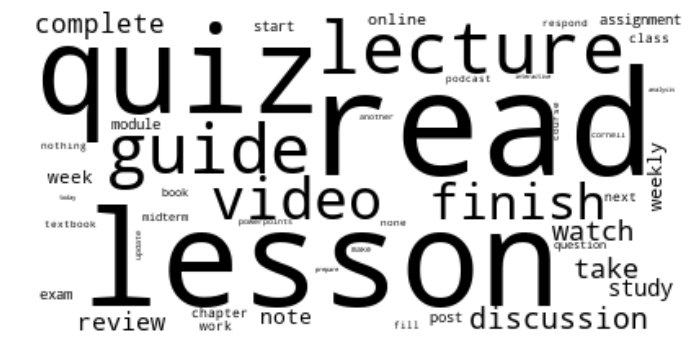

In [10]:
generate_wordcloud(preprocessed_cact)

num_topics = 1   	Coherence Score:  0.4574665630076228	Perplexity: -3.8134552442476677
num_topics = 2   	Coherence Score:  0.6205375236046777	Perplexity: -4.017519819452562
num_topics = 3   	Coherence Score:  0.6823382061341295	Perplexity: -4.202266523706353
num_topics = 4   	Coherence Score:  0.6702075452013827	Perplexity: -4.4280766054450895
num_topics = 5   	Coherence Score:  0.6976722884651739	Perplexity: -4.483492843781359
num_topics = 6   	Coherence Score:  0.6616018684679214	Perplexity: -4.566223614755302
num_topics = 7   	Coherence Score:  0.6697791859682448	Perplexity: -4.623497408859508
num_topics = 8   	Coherence Score:  0.667123227189969	Perplexity: -4.57844611881921
num_topics = 9   	Coherence Score:  0.6619599362325111	Perplexity: -4.754597098946763
num_topics = 10   	Coherence Score:  0.7138309089691961	Perplexity: -4.988131617371968
num_topics = 11   	Coherence Score:  0.6620146666931688	Perplexity: -4.921361098223388


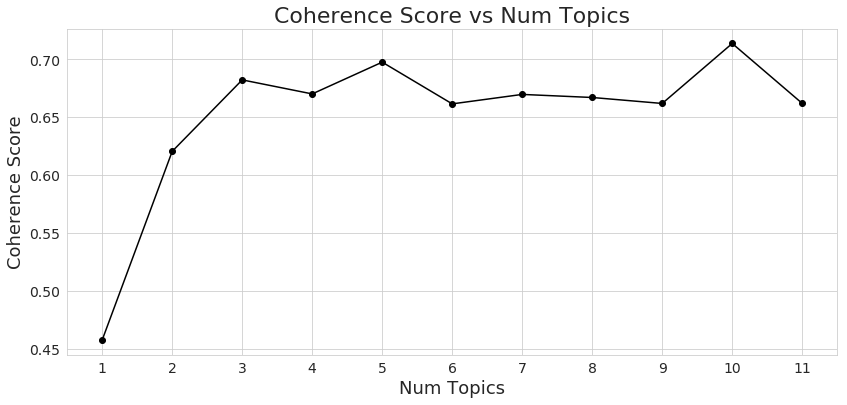

In [15]:
coherence_scores_cact = find_num_topics(1, 11, preprocessed_cact, id2word_cact, corpus_tfidf_cact, 
                                        fname = "../slides_dataviz/plots/lda_cact_coherence.eps")

In [16]:
viz, model_cact_3 = check_topics(3, preprocessed_cact, id2word_cact, corpus_tfidf_cact)

num_topics = 3 	 Coherence Score:  0.6852340982173173 	 Perplexity: -4.20822031894577

Topics: 0 
Words: 0.410*"quiz" + 0.046*"lessons" + 0.036*"post" + 0.035*"exam" + 0.024*"podcast" + 0.020*"class" + 0.020*"advance" + 0.019*"work" + 0.019*"textbook" + 0.016*"update"
Topics: 1 
Words: 0.194*"lecture" + 0.079*"video" + 0.077*"finish" + 0.075*"weekly" + 0.072*"review" + 0.065*"videos" + 0.063*"study" + 0.061*"watch" + 0.026*"discussions" + 0.025*"assignments"
Topics: 2 
Words: 0.237*"read" + 0.173*"lesson" + 0.117*"guide" + 0.083*"discussion" + 0.077*"take" + 0.058*"complete" + 0.041*"week" + 0.028*"online" + 0.016*"note" + 0.015*"midterm"


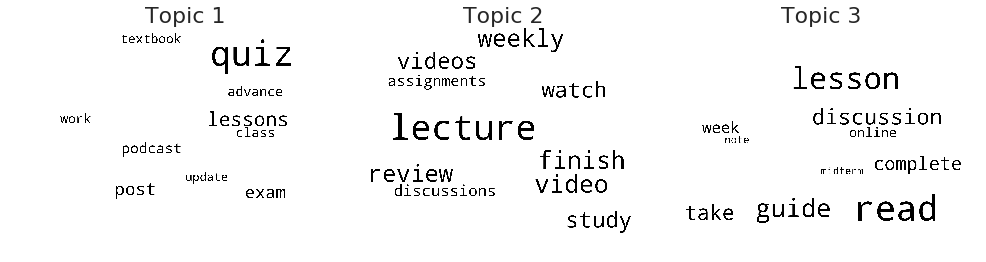

In [17]:
plot_topics(model_cact_3, "../slides_dataviz/plots/lda_cact_model_3_topics.eps", nrow=1, ncol=3)